# Van der Pol Oscillator Verification Comparison

This code compares two verification approaches for controlling a Van der Pol oscillator:
1. CROWN-based verification with neural network controller
2. Numerical gradient-based verification with neural network controller

Both methods train controllers to satisfy reach-avoid specifications, directing the system
to reach a goal region while avoiding unsafe regions.

**Key Concepts:**

**1. Van der Pol Oscillator Dynamics**
- Classical nonlinear oscillator model with limit cycle behavior
- State variables: position (x1) and velocity (x2)
- Control input influences acceleration

**2. Verification Methods**
- CROWN: Differentiable formal verification with interval bound propagation
- Numerical gradient: Finite-difference approximation for reachable sets

**3. Reach-Avoid Specifications**
- Goal region: Small region around origin [−0.05, 0.05]²
- Unsafe region: Region to avoid [(−0.3, −0.25) × (0.2, 0.35)]

In [ ]:
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git@newer-jax-verify

# CROWN-based Controller Training

Starting training...
Epoch 0, Loss: 18.437671661376953, Time elapsed: 31.56s
Epoch 10, Loss: 18.30481719970703, Time elapsed: 31.58s
Epoch 20, Loss: 18.17144203186035, Time elapsed: 31.59s
Epoch 30, Loss: 18.03750228881836, Time elapsed: 31.61s
Epoch 40, Loss: 17.9029598236084, Time elapsed: 31.62s
Epoch 50, Loss: 17.767797470092773, Time elapsed: 31.64s
Epoch 60, Loss: 17.632001876831055, Time elapsed: 31.65s
Epoch 70, Loss: 17.495576858520508, Time elapsed: 31.67s
Epoch 80, Loss: 17.358531951904297, Time elapsed: 31.68s
Epoch 90, Loss: 17.220867156982422, Time elapsed: 31.70s
Epoch 100, Loss: 17.08258056640625, Time elapsed: 31.72s
Epoch 110, Loss: 16.943693161010742, Time elapsed: 31.73s
Epoch 120, Loss: 16.804203033447266, Time elapsed: 31.75s
Epoch 130, Loss: 16.664108276367188, Time elapsed: 31.76s
Epoch 140, Loss: 16.523433685302734, Time elapsed: 31.78s
Epoch 150, Loss: 16.382177352905273, Time elapsed: 31.79s
Epoch 160, Loss: 16.2403507232666, Time elapsed: 31.81s
Epoch 170, L

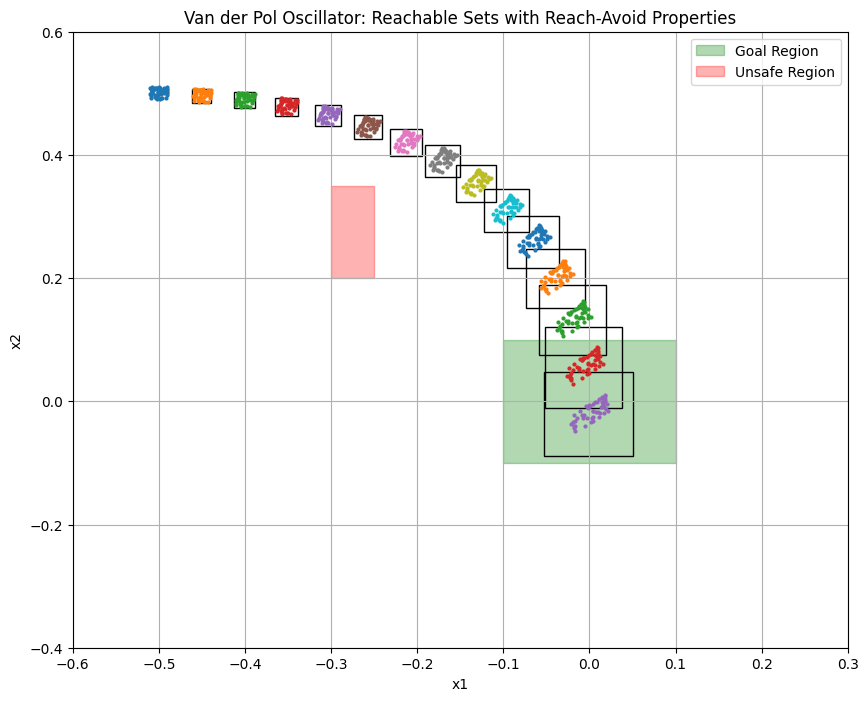

Plotting loss history...


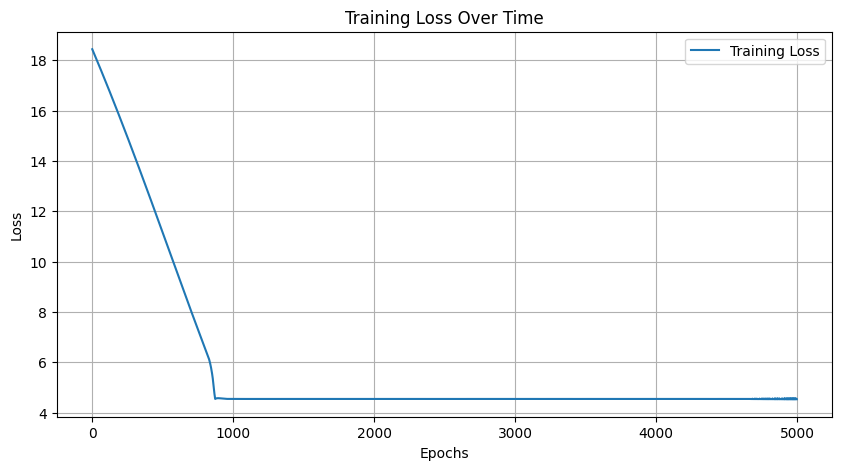

In [ ]:
import jax
import jax.numpy as jnp
from typing import List, Callable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import jax_verify
import functools
import optax
from jax import grad, jit
import time

def relu_nn(params, inputs):
    for W, b in params[:-1]:
        outputs = jnp.dot(inputs, W) + b
        inputs = jnp.maximum(outputs, 0)
    Wout, bout = params[-1]
    outputs = jnp.dot(inputs, Wout) + bout
    return outputs[0]

def init_network_params(layer_sizes, rng_key):
    params = []
    for i in range(1, len(layer_sizes)):
        in_dim = layer_sizes[i - 1]
        out_dim = layer_sizes[i]
        key, rng_key = jax.random.split(rng_key)
        bound = jnp.sqrt(6.0 / (in_dim + out_dim))
        weights = jax.random.uniform(key, (in_dim, out_dim), minval=-bound, maxval=bound)
        biases = jnp.zeros(out_dim)
        params.append((weights, biases))
    return params

layer_sizes = [2, 2, 1]
rng_key = jax.random.PRNGKey(0)
params = init_network_params(layer_sizes, rng_key)
controller = functools.partial(relu_nn, params)

class VanDerPolModel:
    def __init__(self, gamma=1.0):
        self.delta_t = 0.1  # Sampling period
        self.gamma = gamma  # Damping coefficient

    def dynamics_step(self, xs, ut):
        x1, x2 = xs
        u = ut

        x1_new = x1 + x2 * self.delta_t
        x2_new = x2 + (self.gamma * (1 - x1**2) * x2 - x1 + u) * self.delta_t

        return jnp.array([x1_new, x2_new])

dyn = VanDerPolModel()

def plot_multistep_samples_and_bounds(initial_state_range, step_fn, num_steps, bounds_list=None):
    xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(50, 2))
    states = [xt]

    for i in range(num_steps):
        xt1 = jax.vmap(step_fn)(xt)
        states.append(xt1)
        xt = xt1

    plt.figure(figsize=(10, 8))

    goal_set = np.array([[-0.1, 0.1], [-0.1, 0.1]])
    unsafe_set = np.array([[-0.3, -0.25], [0.2, 0.35]])

    unsafe_rect = Rectangle((unsafe_set[0, 0], unsafe_set[1, 0]),
                           unsafe_set[0, 1] - unsafe_set[0, 0],
                           unsafe_set[1, 1] - unsafe_set[1, 0],
                           color='red', alpha=0.3, label='Unsafe Region')
    plt.gca().add_patch(unsafe_rect)

    goal_rect = Rectangle((goal_set[0, 0], goal_set[1, 0]),
                         goal_set[0, 1] - goal_set[0, 0],
                         goal_set[1, 1] - goal_set[1, 0],
                         color='green', alpha=0.3, label='Goal Region')
    plt.gca().add_patch(goal_rect)

    for i in range(len(states)):
        plt.plot(states[i][:, 0], states[i][:, 1], 'o', markersize=2)

    if bounds_list is not None:
        for bounds in bounds_list:
            lower = bounds.lower
            upper = bounds.upper
            width = upper[0] - lower[0]
            height = upper[1] - lower[1]
            rect = Rectangle((lower[0], lower[1]), width, height, fill=False, edgecolor='black', linewidth=1)
            plt.gca().add_patch(rect)

    plt.title('Van der Pol Oscillator: Reachable Sets with Reach-Avoid Properties')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    plt.xlim(-0.6, 0.3)
    plt.ylim(-0.4, 0.6)
    plt.legend(handles=[goal_rect, unsafe_rect])
    plt.show()

def plot_loss_history(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def step_1(xt, params):
    ut = relu_nn(params, xt)
    return dyn.dynamics_step(xt, ut)

def compute_multistep_reachable_set(initial_state_range, step_fn, params, num_steps):
    initial_state_bounds = jax_verify.IntervalBound(initial_state_range[:, 0], initial_state_range[:, 1])
    state_bounds = initial_state_bounds
    state_ranges = []

    for i in range(num_steps):
        next_state_bounds = jax_verify.backward_crown_bound_propagation(functools.partial(step_fn, params=params), state_bounds)
        state_ranges.append(next_state_bounds)
        state_bounds = next_state_bounds

    return state_ranges

def loss_multi_step_reachable_set_volume(reachable_sets):
    volumes = [jnp.prod(set_.upper - set_.lower) for set_ in reachable_sets]
    total_volume = jnp.sum(jnp.array(volumes))
    return total_volume

def loss_reach_avoid(controller_params, initial_state_bounds, num_steps):
    reachable_set = compute_multistep_reachable_set(
        initial_state_bounds,
        functools.partial(step_1),
        controller_params,
        num_steps
    )

    goal_set = jnp.array([[-0.05, 0.05], [-0.05, 0.05]])
    unsafe_set = jnp.array([[-0.3, -0.25], [0.2, 0.35]])

    loss_value = 0.0
    volume_loss = loss_multi_step_reachable_set_volume(reachable_set)

    for i, state_bounds in enumerate(reachable_set):
        state_center = (state_bounds.upper + state_bounds.lower) / 2
        x1, x2 = state_center

        goal_center = jnp.array([0.0, 0.0])  # Center of goal region
        distance_to_goal = jnp.linalg.norm(state_center - goal_center)

        # Checking for overlaps with unsafe region
        overlap_area_unsafe = 0.0
        overlap_lower_unsafe = jnp.maximum(state_bounds.lower, jnp.array([unsafe_set[0, 0], unsafe_set[1, 0]]))
        overlap_upper_unsafe = jnp.minimum(state_bounds.upper, jnp.array([unsafe_set[0, 1], unsafe_set[1, 1]]))
        overlap_width_unsafe = jnp.maximum(overlap_upper_unsafe - overlap_lower_unsafe, 0)
        overlap_area_unsafe = jnp.prod(overlap_width_unsafe)

        # Checking for overlaps with goal region
        overlap_lower_goal = jnp.maximum(state_bounds.lower, jnp.array([goal_set[0, 0], goal_set[1, 0]]))
        overlap_upper_goal = jnp.minimum(state_bounds.upper, jnp.array([goal_set[0, 1], goal_set[1, 1]]))
        overlap_width_goal = jnp.maximum(overlap_upper_goal - overlap_lower_goal, 0)
        overlap_area_goal = jnp.prod(overlap_width_goal)

        step_loss = 1.0*distance_to_goal + 20.0*overlap_area_unsafe - 50.0*overlap_area_goal
        loss_value += step_loss

    combined_loss = loss_value + 0.8*volume_loss
    return combined_loss

def train_controller(params, optimizer, initial_state_range, num_epochs, num_steps, patience=100, threshold=1e-7):
    opt_state = optimizer.init(params)
    best_loss = float('inf')
    best_params = params
    epochs_without_improvement = 0
    loss_history = []

    training_start_time = time.time()

    @jax.jit
    def train_step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss_reach_avoid)(params, initial_state_range, num_steps)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(num_epochs):
        params, opt_state, loss_value = train_step(params, opt_state)
        loss_history.append(loss_value)

        if loss_value < best_loss:
            best_loss = loss_value
            best_params = params
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 10 == 0:
            elapsed_time = time.time() - training_start_time
            print(f"Epoch {epoch}, Loss: {loss_value}, Time elapsed: {elapsed_time:.2f}s")


    total_training_time = time.time() - training_start_time
    print(f"\nTotal training time: {total_training_time:.2f} seconds")
    print(f"Average time per epoch: {total_training_time/max(1, epoch+1):.4f} seconds")

    return best_params, loss_history

initial_state_range = np.array([
    [-0.51, -0.49],  # x1 range
    [0.49, 0.51]     # x2 range
])

num_steps = 14
learning_rate = 0.001
optimizer = optax.adam(learning_rate)
num_epochs = 5000

print("Starting training...")
trained_params1, loss_history = train_controller(
    params, optimizer, jnp.array(initial_state_range), num_epochs, num_steps
)
print("Training completed.")

print("Computing reachable sets using trained controller...")
output_ranges1 = compute_multistep_reachable_set(initial_state_range, step_1, trained_params1, num_steps)

print("\nReachable Set Bounds at Each Step:")
for i, bounds in enumerate(output_ranges1):
    print(f"Step {i}:")
    print(f"  x1: [{bounds.lower[0]:.4f}, {bounds.upper[0]:.4f}]")
    print(f"  x2: [{bounds.lower[1]:.4f}, {bounds.upper[1]:.4f}]")


print("\nPlotting reachable sets and sampling trajectories...")
plot_multistep_samples_and_bounds(
    initial_state_range,
    functools.partial(step_1, params=trained_params1),
    num_steps,
    bounds_list=output_ranges1
)

print("Plotting loss history...")
plot_loss_history(loss_history)

# Finite Difference Training

Starting training using difference method (as described in the paper)...
Epoch 0, Loss: 16.1753, Time elapsed: 0.00s
Epoch 10, Loss: 8.2079, Time elapsed: 0.34s
Epoch 20, Loss: 5.7545, Time elapsed: 0.66s
Epoch 30, Loss: 6.6519, Time elapsed: 1.02s
Epoch 40, Loss: 6.2183, Time elapsed: 1.34s
Epoch 50, Loss: 6.1243, Time elapsed: 1.67s
Epoch 60, Loss: 6.0459, Time elapsed: 2.00s
Epoch 70, Loss: 7.0321, Time elapsed: 2.31s
Epoch 80, Loss: 7.8201, Time elapsed: 2.65s
Epoch 90, Loss: 5.9668, Time elapsed: 2.99s
Epoch 100, Loss: 6.1241, Time elapsed: 3.45s
Epoch 110, Loss: 6.0142, Time elapsed: 4.05s
Epoch 120, Loss: 5.3115, Time elapsed: 4.59s
Epoch 130, Loss: 6.0246, Time elapsed: 5.16s
Epoch 140, Loss: 6.1828, Time elapsed: 5.73s
Epoch 150, Loss: 6.7127, Time elapsed: 6.15s
Epoch 160, Loss: 7.1401, Time elapsed: 6.46s
Epoch 170, Loss: 7.0099, Time elapsed: 6.77s
Epoch 180, Loss: 6.9741, Time elapsed: 7.09s
Epoch 190, Loss: 6.8719, Time elapsed: 7.43s
Epoch 200, Loss: 6.9354, Time elapsed

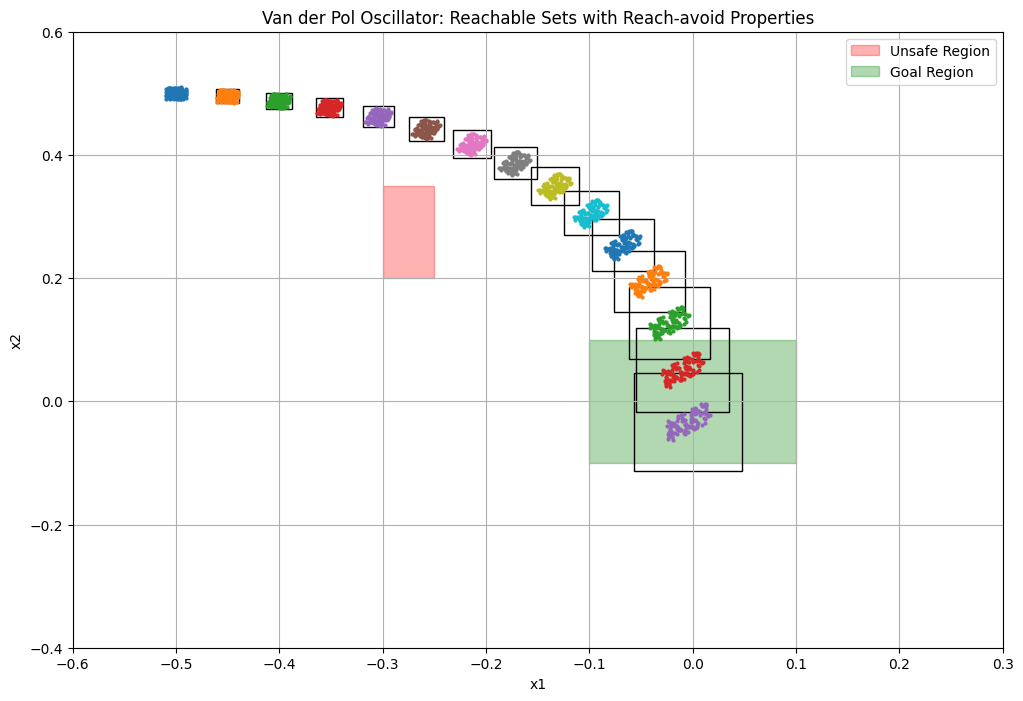

Plotting loss history...


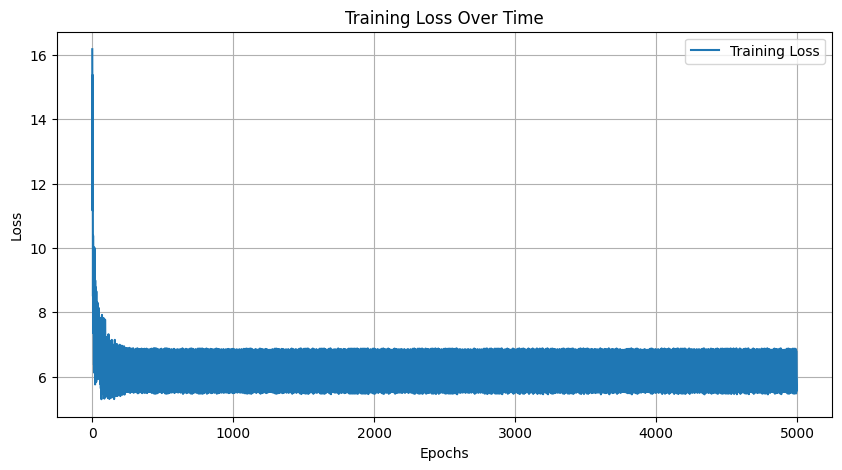

In [ ]:
import jax
import jax.numpy as jnp
from typing import List, Callable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import functools
import time

class IntervalBound:
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper

    def __repr__(self):
        return f"IntervalBound(lower={self.lower}, upper={self.upper})"

def relu_nn(params, inputs):
    W1, b1 = params[0]
    W2, b2 = params[1]

    hidden = np.maximum(np.dot(inputs, W1) + b1, 0)
    output = np.dot(hidden, W2) + b2
    return output[0]

def init_network_params(layer_sizes, seed=0):
    np.random.seed(seed)
    params = []
    for i in range(1, len(layer_sizes)):
        in_dim = layer_sizes[i - 1]
        out_dim = layer_sizes[i]

        if i < len(layer_sizes) - 1:
            scale = np.sqrt(2.0 / in_dim)
        else:
            scale = np.sqrt(1.0 / in_dim)

        weights = np.random.normal(0, scale, (in_dim, out_dim))
        biases = np.zeros(out_dim)
        params.append((weights, biases))
    return params

layer_sizes = [2, 2, 1]
params = init_network_params(layer_sizes)

class VanDerPolModel:
    def __init__(self, gamma=1.0):
        self.delta_t = 0.1  # Sampling period
        self.gamma = gamma  # Damping coefficient

    def dynamics_step(self, xs, ut):
        x1, x2 = xs
        u = ut

        x1_new = x1 + x2 * self.delta_t
        x2_new = x2 + (self.gamma * (1 - x1**2) * x2 - x1 + u) * self.delta_t

        return np.array([x1_new, x2_new])

dyn = VanDerPolModel()

def compute_nn_output_bounds(params, input_bounds):
    lower_input, upper_input = input_bounds.lower, input_bounds.upper

    x1_values = [lower_input[0], upper_input[0]]
    x2_values = [lower_input[1], upper_input[1]]

    corner_points = np.array([
        [x1, x2] for x1 in x1_values for x2 in x2_values
    ])

    outputs = np.array([relu_nn(params, point) for point in corner_points])

    lower_output = np.min(outputs)
    upper_output = np.max(outputs)

    return lower_output, upper_output

def compute_dynamics_bounds(input_bounds, u_bounds, dyn_model):
    lower_input, upper_input = input_bounds.lower, input_bounds.upper
    lower_u, upper_u = u_bounds


    x1_values = [lower_input[0], upper_input[0]]
    x2_values = [lower_input[1], upper_input[1]]
    u_values = [lower_u, upper_u]

    next_states = []
    for x1 in x1_values:
        for x2 in x2_values:
            for u in u_values:
                next_state = dyn_model.dynamics_step([x1, x2], u)
                next_states.append(next_state)

    next_states = np.array(next_states)

    lower_output = np.min(next_states, axis=0)
    upper_output = np.max(next_states, axis=0)

    epsilon = 1e-7
    lower_output -= epsilon
    upper_output += epsilon

    return IntervalBound(lower_output, upper_output)

def compute_reachable_set(initial_state_range, step_fn, params, num_steps):
    initial_state_bounds = IntervalBound(
        np.array(initial_state_range[:, 0]),
        np.array(initial_state_range[:, 1])
    )

    state_bounds = initial_state_bounds
    state_ranges = [state_bounds]

    for i in range(num_steps):
        u_bounds = compute_nn_output_bounds(params, state_bounds)

        next_state_bounds = compute_dynamics_bounds(state_bounds, u_bounds, dyn)

        state_ranges.append(next_state_bounds)
        state_bounds = next_state_bounds

    return state_ranges[1:]

def plot_multistep_samples_and_bounds(initial_state_range, step_fn, params, num_steps, bounds_list=None):
    xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(100, 2))
    states = [xt]

    for i in range(num_steps):
        xt_next = np.zeros_like(xt)
        for j, x in enumerate(xt):
            u = relu_nn(params, x)
            xt_next[j] = dyn.dynamics_step(x, u)

        states.append(xt_next)
        xt = xt_next.copy()

    plt.figure(figsize=(12, 8))

    goal_set = np.array([[-0.1, 0.1], [-0.1, 0.1]])
    unsafe_set = np.array([[-0.3, -0.25], [0.2, 0.35]])

    plt.gca().set_facecolor('white')

    plt.xlim(-0.6, 0.3)
    plt.ylim(-0.4, 0.6)

    unsafe_rect = Rectangle((unsafe_set[0, 0], unsafe_set[1, 0]),
                           unsafe_set[0, 1] - unsafe_set[0, 0],
                           unsafe_set[1, 1] - unsafe_set[1, 0],
                           color='red', alpha=0.3, label='Unsafe Region')
    plt.gca().add_patch(unsafe_rect)

    goal_rect = Rectangle((goal_set[0, 0], goal_set[1, 0]),
                         goal_set[0, 1] - goal_set[0, 0],
                         goal_set[1, 1] - goal_set[1, 0],
                         color='green', alpha=0.3, label='Goal Region')
    plt.gca().add_patch(goal_rect)

    for i in range(len(states)):
        plt.plot(states[i][:, 0], states[i][:, 1], 'o', markersize=2)

    if bounds_list is not None:
        for bounds in bounds_list:
            lower = bounds.lower
            upper = bounds.upper
            width = upper[0] - lower[0]
            height = upper[1] - lower[1]
            rect = Rectangle((lower[0], lower[1]), width, height,
                             fill=False, edgecolor='black', linewidth=1)
            plt.gca().add_patch(rect)

    plt.title('Van der Pol Oscillator: Reachable Sets with Reach-avoid Properties')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_loss_history(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_geometric_distances(reachable_sets, goal_set, unsafe_set):
    safety_distance = float('inf')
    goal_distance = float('-inf')

    for state_bounds in reachable_sets:
        lower = state_bounds.lower
        upper = state_bounds.upper

        if (upper[0] >= unsafe_set[0, 0] and lower[0] <= unsafe_set[0, 1] and
            upper[1] >= unsafe_set[1, 0] and lower[1] <= unsafe_set[1, 1]):
            overlap_lower = np.maximum(lower, [unsafe_set[0, 0], unsafe_set[1, 0]])
            overlap_upper = np.minimum(upper, [unsafe_set[0, 1], unsafe_set[1, 1]])
            overlap_area = np.prod(np.maximum(overlap_upper - overlap_lower, 0))
            safety_distance = min(safety_distance, -overlap_area)
        else:
            # Compute distance to unsafe region
            dx = max(0, lower[0] - unsafe_set[0, 1]) + max(0, unsafe_set[0, 0] - upper[0])
            dy = max(0, lower[1] - unsafe_set[1, 1]) + max(0, unsafe_set[1, 0] - upper[1])
            distance = np.sqrt(dx**2 + dy**2)
            safety_distance = min(safety_distance, distance)

        # Check for intersection with goal region (goal-reaching)
        if (upper[0] >= goal_set[0, 0] and lower[0] <= goal_set[0, 1] and
            upper[1] >= goal_set[1, 0] and lower[1] <= goal_set[1, 1]):
            # Compute positive area of intersection
            overlap_lower = np.maximum(lower, [goal_set[0, 0], goal_set[1, 0]])
            overlap_upper = np.minimum(upper, [goal_set[0, 1], goal_set[1, 1]])
            overlap_area = np.prod(np.maximum(overlap_upper - overlap_lower, 0))
            goal_distance = max(goal_distance, overlap_area)
        else:
            # Compute negative distance to goal region
            dx = max(0, goal_set[0, 0] - upper[0]) + max(0, lower[0] - goal_set[0, 1])
            dy = max(0, goal_set[1, 0] - upper[1]) + max(0, lower[1] - goal_set[1, 1])
            distance = -np.sqrt(dx**2 + dy**2)
            goal_distance = max(goal_distance, distance)

    return safety_distance, goal_distance

def compute_volume_loss(reachable_sets):
    volumes = [np.prod(bounds.upper - bounds.lower) for bounds in reachable_sets]
    total_volume = np.sum(volumes)
    return total_volume

def loss_reach_avoid(controller_params, initial_state_bounds, num_steps, goal_set, unsafe_set, lambda_weight=1.0):
    reachable_sets = compute_reachable_set(
        initial_state_bounds,
        None,
        controller_params,
        num_steps
    )

    safety_distance, goal_distance = compute_geometric_distances(reachable_sets, goal_set, unsafe_set)

    volume_loss = compute_volume_loss(reachable_sets)

    loss_value = 0.0

    for i, state_bounds in enumerate(reachable_sets):
        state_center = (state_bounds.upper + state_bounds.lower) / 2
        x1, x2 = state_center

        # Distance to goal region
        goal_center = np.array([0.0, 0.0])  # Center of goal region
        distance_to_goal = np.linalg.norm(state_center - goal_center)

        # Checking for overlaps with unsafe region
        overlap_area_unsafe = 0.0
        overlap_lower_unsafe = np.maximum(state_bounds.lower, [unsafe_set[0, 0], unsafe_set[1, 0]])
        overlap_upper_unsafe = np.minimum(state_bounds.upper, [unsafe_set[0, 1], unsafe_set[1, 1]])
        overlap_width_unsafe = np.maximum(overlap_upper_unsafe - overlap_lower_unsafe, 0)
        overlap_area_unsafe = np.prod(overlap_width_unsafe)

        # Checking for overlaps with goal region
        overlap_lower_goal = np.maximum(state_bounds.lower, [goal_set[0, 0], goal_set[1, 0]])
        overlap_upper_goal = np.minimum(state_bounds.upper, [goal_set[0, 1], goal_set[1, 1]])
        overlap_width_goal = np.maximum(overlap_upper_goal - overlap_lower_goal, 0)
        overlap_area_goal = np.prod(overlap_width_goal)

        step_loss = 1.0*distance_to_goal + 5.0*overlap_area_unsafe - 60.0*overlap_area_goal
        loss_value += step_loss

    combined_loss = loss_value + 15*volume_loss

    return combined_loss, reachable_sets, safety_distance, goal_distance

def train_controller_with_diff_method(params, learning_rate, initial_state_range, num_epochs, num_steps,
                                     goal_set, unsafe_set):
    """Train controller using difference method for gradient approximation as in the paper"""
    best_loss = float('inf')
    best_params = [(np.array(w).copy(), np.array(b).copy()) for w, b in params]
    epochs_without_improvement = 0
    loss_history = []
    is_satisfied = False

    training_start_time = time.time()

    best_safety = -float('inf')
    best_goal = -float('inf')

    for epoch in range(num_epochs):
        base_loss, reachable_sets, safety_distance, goal_distance = loss_reach_avoid(
            params, initial_state_range, num_steps, goal_set, unsafe_set
        )

        is_safe = safety_distance > 0
        reaches_goal = goal_distance > 0

        loss_history.append(base_loss)

        if base_loss < best_loss:
            best_loss = base_loss
            best_params = [(np.array(w).copy(), np.array(b).copy()) for w, b in params]
            best_safety = safety_distance
            best_goal = goal_distance
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 10 == 0:
            elapsed_time = time.time() - training_start_time
            print(f"Epoch {epoch}, Loss: {base_loss:.4f}, Time elapsed: {elapsed_time:.2f}s")

            if is_safe and reaches_goal and not is_satisfied:
                is_satisfied = True


        gradients = []
        epsilon = 0.02

        for i, (W, b) in enumerate(params):
            W_grad = np.zeros_like(W)
            for j in range(W.shape[0]):
                for k in range(W.shape[1]):
                    params_pos = [(np.array(w).copy(), np.array(bias).copy()) for w, bias in params]
                    params_pos[i] = (W.copy(), b.copy())
                    params_pos[i][0][j, k] += epsilon

                    params_neg = [(np.array(w).copy(), np.array(bias).copy()) for w, bias in params]
                    params_neg[i] = (W.copy(), b.copy())
                    params_neg[i][0][j, k] -= epsilon

                    pos_loss, _, _, _ = loss_reach_avoid(params_pos, initial_state_range, num_steps, goal_set, unsafe_set)
                    neg_loss, _, _, _ = loss_reach_avoid(params_neg, initial_state_range, num_steps, goal_set, unsafe_set)

                    W_grad[j, k] = (pos_loss - neg_loss) / (2 * epsilon)

            b_grad = np.zeros_like(b)
            for j in range(b.shape[0]):
                params_pos = [(np.array(w).copy(), np.array(bias).copy()) for w, bias in params]
                params_pos[i] = (W.copy(), b.copy())
                params_pos[i][1][j] += epsilon

                params_neg = [(np.array(w).copy(), np.array(bias).copy()) for w, bias in params]
                params_neg[i] = (W.copy(), b.copy())
                params_neg[i][1][j] -= epsilon

                pos_loss, _, _, _ = loss_reach_avoid(params_pos, initial_state_range, num_steps, goal_set, unsafe_set)
                neg_loss, _, _, _ = loss_reach_avoid(params_neg, initial_state_range, num_steps, goal_set, unsafe_set)

                b_grad[j] = (pos_loss - neg_loss) / (2 * epsilon)

            gradients.append((W_grad, b_grad))

        for i, ((W, b), (W_grad, b_grad)) in enumerate(zip(params, gradients)):
            params[i] = (W - learning_rate * W_grad, b - learning_rate * b_grad)

    total_training_time = time.time() - training_start_time
    print(f"Total training time: {total_training_time:.2f} seconds")
    print(f"Average time per epoch: {total_training_time/max(1, epoch+1):.4f} seconds")
    print("Training completed.")

    return best_params, loss_history

initial_state_range = np.array([
    [-0.51, -0.49],
    [0.49, 0.51]
])

goal_set = np.array([
    [-0.05, 0.05],
    [-0.05, 0.05]
])

unsafe_set = np.array([
    [-0.3, -0.25],
    [0.2, 0.35]
])

num_steps = 14
learning_rate = 0.01
num_epochs = 5000

print("Starting training using difference method (as described in the paper)...")
trained_params, loss_history = train_controller_with_diff_method(
    params, learning_rate, initial_state_range, num_epochs, num_steps,
    goal_set, unsafe_set
)
print("Training completed.")

print("Computing reachable sets using trained controller...")
output_ranges = compute_reachable_set(initial_state_range, None, trained_params, num_steps)

print("\nReachable Set Bounds at Each Step:")
for i, bounds in enumerate(output_ranges):
    print(f"Step {i+1}:")
    print(f"  x1: [{bounds.lower[0]:.4f}, {bounds.upper[0]:.4f}]")
    print(f"  x2: [{bounds.lower[1]:.4f}, {bounds.upper[1]:.4f}]")

safety_distance, goal_distance = compute_geometric_distances(output_ranges, goal_set, unsafe_set)
print(f"\nFinal safety distance: {safety_distance:.6f}")
print(f"Final goal-reaching distance: {goal_distance:.6f}")
print(f"Is safe: {safety_distance > 0}")
print(f"Reaches goal: {goal_distance > 0}")

print("\nPlotting reachable sets and sampling trajectories...")
plot_multistep_samples_and_bounds(
    initial_state_range,
    None,
    trained_params,
    num_steps,
    bounds_list=output_ranges
)

print("Plotting loss history...")
plot_loss_history(loss_history)

# Combined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

def plot_combined_multistep_samples_and_bounds(initial_state_range, params_list, num_steps,
                                   bounds_lists=None, labels=None, seed=42):

    if bounds_lists is None:
        bounds_lists = [None] * len(params_list)

    if labels is None:
        labels = [f"Controller {i+1}" for i in range(len(params_list))]

    np.random.seed(seed)

    xt_initial = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(200, 2))

    goal_set = np.array([[-0.1, 0.1], [-0.1, 0.1]])
    unsafe_set = np.array([[-0.3, -0.25], [0.2, 0.35]])

    xlim = (-0.6, 0.3)
    ylim = (-0.4, 0.6)

    n_controllers = len(params_list)
    fig, axes = plt.subplots(1, n_controllers, figsize=(9*n_controllers, 8), sharey=True)

    if n_controllers == 1:
        axes = [axes]

    color_list = []
    tab_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    color_list.extend(tab_colors)
    tab_colors_b = plt.cm.tab20b(np.linspace(0, 1, 20))
    color_list.extend(tab_colors_b)
    tab_colors_c = plt.cm.tab20c(np.linspace(0, 1, 20))
    color_list.extend(tab_colors_c)

    legend_handles = []
    legend_labels = []

    for controller_idx, (params, bounds_list, label, ax) in enumerate(zip(params_list, bounds_lists, labels, axes)):
        ax.set_facecolor('white')

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.grid(True, linestyle='--', alpha=0.6)

        unsafe_rect = Rectangle((unsafe_set[0, 0], unsafe_set[1, 0]),
                               unsafe_set[0, 1] - unsafe_set[0, 0],
                               unsafe_set[1, 1] - unsafe_set[1, 0],
                               color='red', alpha=0.3)
        ax.add_patch(unsafe_rect)

        if controller_idx == 0:
            legend_handles.append(unsafe_rect)
            legend_labels.append('Unsafe Region')

        goal_rect = Rectangle((goal_set[0, 0], goal_set[1, 0]),
                             goal_set[0, 1] - goal_set[0, 0],
                             goal_set[1, 1] - goal_set[1, 0],
                             color='green', alpha=0.3)
        ax.add_patch(goal_rect)

        if controller_idx == 0:
            legend_handles.append(goal_rect)
            legend_labels.append('Goal Region')

        init_x_mid = (initial_state_range[0, 0] + initial_state_range[0, 1]) / 2
        init_y_mid = (initial_state_range[1, 0] + initial_state_range[1, 1]) / 2
        init_width = initial_state_range[0, 1] - initial_state_range[0, 0]
        init_height = initial_state_range[1, 1] - initial_state_range[1, 0]

        init_rect = Rectangle((initial_state_range[0, 0], initial_state_range[1, 0]),
                             init_width, init_height,
                             fill=True, facecolor='red', edgecolor='black',
                             linewidth=2, alpha=0.3, zorder=5)
        ax.add_patch(init_rect)
        ax.text(init_x_mid - 0.05, init_y_mid, 'START',
                ha='center', va='center',
                color='white', fontweight='bold', fontsize=14,
                bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.5'),
                zorder=15)

        goal_x_mid = (goal_set[0, 0] + goal_set[0, 1]) / 2
        goal_y_mid = (goal_set[1, 0] + goal_set[1, 1]) / 2

        ax.scatter(goal_x_mid, goal_y_mid - 0.05, s=300, marker='*', color='gold',
                  edgecolor='black', linewidth=1.5, zorder=19)

        ax.text(goal_x_mid, goal_y_mid + 0.05, 'GOAL',
                ha='center', va='center',
                color='black', fontweight='bold', fontsize=14,
                bbox=dict(facecolor='green', alpha=0.7, boxstyle='round,pad=0.5'),
                zorder=20)

        xt = xt_initial.copy()
        states = [xt.copy()]

        for i in range(num_steps):
            xt_next = np.zeros_like(xt)
            for j, x in enumerate(xt):
                u = relu_nn(params, x)
                xt_next[j] = dyn.dynamics_step(x, u)

            states.append(xt_next)
            xt = xt_next.copy()

        for i in range(len(states)):
            color = color_list[i % len(color_list)]
            ax.plot(states[i][:, 0], states[i][:, 1], 'o', color=color, markersize=2,
                    markeredgecolor='black', markeredgewidth=0.15)

        if bounds_list is not None:
            for i, bounds in enumerate(bounds_list):
                lower = bounds.lower
                upper = bounds.upper
                width = upper[0] - lower[0]
                height = upper[1] - lower[1]
                rect = Rectangle((lower[0], lower[1]), width, height,
                                 fill=False, edgecolor='black', linewidth=1)
                ax.add_patch(rect)

                if controller_idx == 0 and i == 0:
                    legend_handles.append(rect)
                    legend_labels.append('Reachable Sets')

        ax.set_xlabel('x1', fontsize=16)

        if controller_idx == 0:
            ax.set_ylabel('x2', fontsize=16)

    fig.legend(legend_handles, legend_labels, loc='upper center',
               bbox_to_anchor=(0.5, 1.05), ncol=min(4, len(legend_handles)),
               fontsize=18, framealpha=0.9, edgecolor='black', markerscale=2.0)

    plt.tight_layout()
    fig.subplots_adjust(top=0.95)

    plt.savefig('combined_van_der_pol.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig, axes

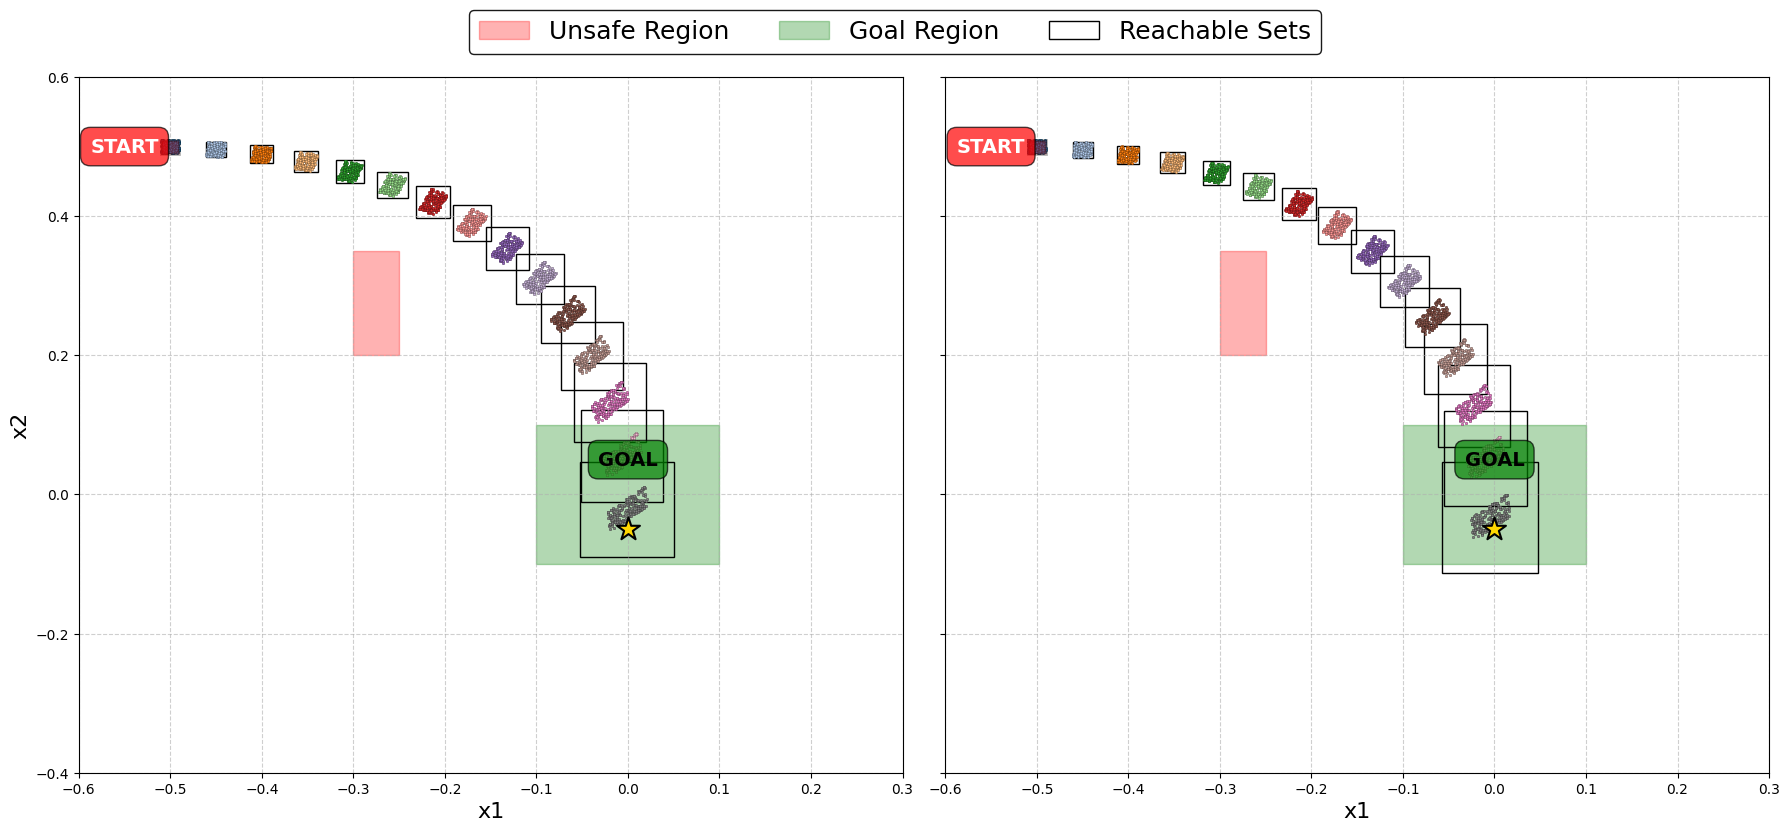

(<Figure size 1800x800 with 2 Axes>,
 array([<Axes: xlabel='x1', ylabel='x2'>, <Axes: xlabel='x1'>],
       dtype=object))

In [ ]:
plot_combined_multistep_samples_and_bounds(
    initial_state_range,
    [trained_params1, trained_params],
    num_steps,
    [output_ranges1, output_ranges],
)